# 动漫评分的分析和推荐

相关推荐对于视频网站而言是非常重要的，可以有效地提高用户的使用时间和黏性。而动漫领域作为一个新兴的视频领域分支，拥有着广阔的市场和可观的前景。本项目基于Kaggle上的数据集，获取动漫的相关信息和用户对其的评价。在对整体情况进行可视化分析后，实现两种不同算法的推荐系统，并基于特定样例分析两者的优劣。



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#清洗数据" data-toc-modified-id="清洗数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>清洗数据</a></span></li><li><span><a href="#数据分析和可视化" data-toc-modified-id="数据分析和可视化-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据分析和可视化</a></span><ul class="toc-item"><li><span><a href="#分析作品的类型" data-toc-modified-id="分析作品的类型-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>分析作品的类型</a></span></li><li><span><a href="#分析作品的标签" data-toc-modified-id="分析作品的标签-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>分析作品的标签</a></span></li><li><span><a href="#计算作品的平均得分" data-toc-modified-id="计算作品的平均得分-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>计算作品的平均得分</a></span></li><li><span><a href="#计算每部作品的评价人数" data-toc-modified-id="计算每部作品的评价人数-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>计算每部作品的评价人数</a></span></li></ul></li><li><span><a href="#动漫推荐" data-toc-modified-id="动漫推荐-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>动漫推荐</a></span><ul class="toc-item"><li><span><a href="#清洗数据" data-toc-modified-id="清洗数据-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>清洗数据</a></span></li><li><span><a href="#使用KNN进行推荐" data-toc-modified-id="使用KNN进行推荐-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>使用KNN进行推荐</a></span></li><li><span><a href="#使用矩阵分解进行推荐" data-toc-modified-id="使用矩阵分解进行推荐-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>使用矩阵分解进行推荐</a></span></li></ul></li><li><span><a href="#总结" data-toc-modified-id="总结-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>总结</a></span></li></ul></div>

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
from pyecharts import options as opts
from pyecharts.charts import Bar,Line,Pie,WordCloud
from pyecharts.globals import ThemeType
from pyecharts.globals import WarningType
WarningType.ShowWarning = False

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [6]:

anime_data=pd.read_csv('./anime.csv')
rating_data=pd.read_csv('./rating.csv')

## 清洗数据

删除评分中为-1，也即没有评价的部分。合并用户评分和动漫信息，获取每个用户对作品的评分，然后去除其中具有缺失值的部分。由于合并之后的表很大而缺失值很少，直接删除不会影响其结果。

删除缺失值后，由于数据中存在一些特殊字符，使用正则表达式对数据进行进一步的清洗。

In [7]:
rating_data = rating_data[~rating_data['rating'].isin([-1])]

anime_fulldata=pd.merge(anime_data,rating_data,on='anime_id',suffixes= ['', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata.dropna(axis = 0,how = 'any')

#Sharingan copy:https://www.kaggle.com/indralin/try-content-based-and-collaborative-filtering
import re
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_data['name'] = anime_data['name'].apply(text_cleaning)
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10


## 数据分析和可视化

### 分析作品的类型

项目先统计了各个类型的作品数量，并绘制了扇形图。可以看出，TV动画占了所有作品的绝大多数，这也是我们接下去主要分析的对象。

In [8]:
labels = list(anime_fulldata['type'].value_counts().index)
values = [4364294, 842153, 617166, 421628, 72123, 19871]#list(anime_fulldata['type'].value_counts().values)
data_pair = [list(z) for z in zip(labels,values)]
data_pair.sort(key=lambda x: x[1])
pie = Pie()
pie.add("",data_pair=data_pair,rosetype="radius")
pie.set_global_opts(title_opts=opts.TitleOpts(title="Distribution of Anime"))
pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
pie.render_notebook()

### 分析作品的标签

在数据集中，每个作品都有若干个标签，显示它们的主题类型。我们采用词云展示不同的标签和所占的比例。

从数量上看，`Comedy,Action,Romance`所占数量最多。但从平均得分上看，`Thriller,Police,Josei`的得分最高。从总体上看，平均得分高的标签的数量都不多，也就是说，从统计上看，小众类型的作品的得分会相对高一些。

In [9]:
anime_fulldata.dropna(axis=0,how='any',inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in anime_fulldata['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1




In [10]:

word_cloud = WordCloud()
word_cloud.add(series_name="Tag", data_pair=list(all_genres.items()), word_size_range=[6, 66])
word_cloud.set_global_opts(
        title_opts=opts.TitleOpts(
            title="Tag Distribution", title_textstyle_opts=opts.TextStyleOpts(font_size=23)
        ),
        tooltip_opts=opts.TooltipOpts(is_show=True),
    )   
word_cloud.render_notebook()

In [11]:
anime_genre_rate = list(np.array(anime_fulldata[['user_rating','genre']]))
genres_rate = {}
for i in all_genres.items():
    genres_rate[i[0]] = 0
for i in anime_genre_rate:
    rating = i[0]
    for genre in i[1].split(','):
        genres_rate[genre.strip()] += rating
for i in genres_rate.items():
    genres_rate[i[0]] = i[1]/all_genres[i[0]]

genres_rate = sorted(genres_rate.items(), key = lambda kv:kv[1],reverse=True)
genre_name = [x[0] for x in genres_rate]
genre_rating = [x[1] for x in genres_rate]

In [12]:
word_cloud = WordCloud()
word_cloud.add(series_name="Tag", data_pair=list(genres_rate), word_size_range=[6, 66])
word_cloud.set_global_opts(
        title_opts=opts.TitleOpts(
            title="Tag Rating", title_textstyle_opts=opts.TextStyleOpts(font_size=23)
        ),
        tooltip_opts=opts.TooltipOpts(is_show=True),
    )   
word_cloud.render_notebook()

### 计算作品的平均得分

然后，分析观众对作品评分的大致情况。于是考虑计算作品的平均得分，并绘制作品评分的折线图，同时绘制用户评分的直方图。可以看出，绝大部分作品的平均得分都在8分左右，而用户的评分也都集中在8分左右，这两者是相符的。据此，在后续的分析中，可以认为评分在9分及以上的作品是用户明显喜爱的作品。

In [13]:
# Creating a dataframe for rating counts
combine_anime_rating = anime_fulldata.dropna(axis = 0, subset = ['anime_title'])
anime_ratingCount = (combine_anime_rating.
     groupby(by = ['anime_title'])['user_rating'].
     mean().
     reset_index().rename(columns = {'rating': 'totalRatingMean'})
    [['anime_title', 'user_rating']]
    )

In [14]:
all_animerating=anime_ratingCount[['anime_title', 'user_rating']].sort_values(by = 'user_rating',ascending = False)

line = Line()
line.add_xaxis(list(range(len(all_animerating['anime_title']))))
line.add_yaxis("User Rating",list(all_animerating["user_rating"]))
line.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
line.set_global_opts(
        title_opts=opts.TitleOpts(title="User Rating"),
    )
line.render_notebook()

Text(0.5, 1.0, 'Rating of users')

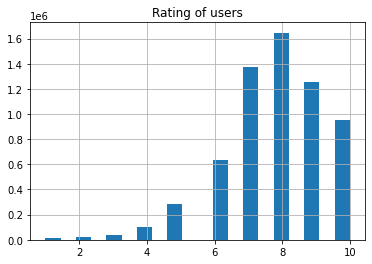

In [15]:
anime_fulldata['user_rating'].hist(bins=20)
plt.title("Rating of users")

### 计算每部作品的评价人数

除了每部作品的平均得分，我们也关心作品的人气，在这里用评分的人数进行衡量。分别绘制评分人数TOP10作品的直方图和全部作品的折线图，为了使表达更清晰，折线图采用log作为纵坐标。

TOP10人气的作品评价人数相差不多，分别是：

1. 死亡笔记
2. 进击的巨人
3. 刀剑神域
4. 钢之炼金术师
5. 天使的心跳
6. 叛逆的鲁鲁修
7. 火影忍者
8. 命运石之门
9. 未来日记
10. 龙与虎

考察TOP10人气作品的标签，绘制直方图。可以发现，`Action,Shounen(少年)`是出现频率最多的，可见人气最高的动画大多是热血王道类型的。

对折线图进行分析，曲线在取对数后呈线性，说明作品的观看人数呈现较为明显的长尾分布。

In [16]:
anime_fulldata = anime_fulldata.merge(anime_ratingCount, left_on = 'anime_title', right_on = 'anime_title', how = 'left')
anime_fulldata = anime_fulldata.rename(columns={'user_rating_x': 'user_rating', 'user_rating_y': 'totalMeanRating'})

In [17]:
duplicate_anime=anime_fulldata.drop_duplicates(subset ="anime_title", 
                     keep = 'first')
duplicate_anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9892 entries, 0 to 6337145
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         9892 non-null   int64  
 1   anime_title      9892 non-null   object 
 2   genre            9892 non-null   object 
 3   type             9892 non-null   object 
 4   episodes         9892 non-null   object 
 5   rating           9892 non-null   float64
 6   members          9892 non-null   int64  
 7   user_id          9892 non-null   int64  
 8   user_rating      9892 non-null   int64  
 9   totalMeanRating  9892 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 850.1+ KB


In [18]:
duplicate_anime.head(10)

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating,totalMeanRating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,9.426313
1961,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3,10,9.322741
23455,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,43,10,9.449495
24643,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,5,9,9.261326
41794,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,5,9,9.272552
44909,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,17,9,9.171484
45947,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,7,9,9.234586
53424,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,183,10,9.389788
54227,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,5,10,9.191430
56374,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,5,8,9.202258


In [19]:
animemembers=duplicate_anime[['anime_title', 'members']].sort_values(by = 'members',ascending = False)

bar = Bar()
bar.add_xaxis(list(animemembers["anime_title"].head(10)))
bar.add_yaxis("Community Size",list(animemembers["members"].head(10)))
bar.set_global_opts(
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
        title_opts=opts.TitleOpts(title="Top 10 Anime based on members"),
    )
bar.render_notebook()

In [20]:
top_anime = duplicate_anime[duplicate_anime['anime_title'].isin(list(animemembers["anime_title"].head(10)))]

tag = {}
for i in top_anime['genre']:
    tags = i.split(',')
    for t in tags:
        if t.strip() in tag:
            tag[t.strip()] += 1
        else:
            tag[t.strip()] = 1
tag = sorted(tag.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)

bar = Bar()
bar.add_xaxis([x[0] for x in tag])
bar.add_yaxis("",[x[1] for x in tag])
bar.set_global_opts(
    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-45))
)
bar.render_notebook()

In [21]:
line = Line()
line.add_xaxis(list(range(len(animemembers["anime_title"]))))
line.add_yaxis("Community Size",list(animemembers["members"]))
line.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
line.set_global_opts(
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
        title_opts=opts.TitleOpts(title="All Anime based on members"),
        yaxis_opts=opts.AxisOpts(
            type_="log",
            name="members",
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True,
        ),
    )
line.render_notebook()

## 动漫推荐

在对动漫的整体情况进行分析后，我们希望能根据用户对作品的评分给用户进行推荐。具体来说，推荐采用两种算法。

首先，对于观看作品较少的用户，我们对其的了解较少，难以准确判断ta的喜好。这种情况往往被称为冷启动问题，为了解决这一问题，我们考虑利用ta已经看过的作品，采用KNN推荐和ta评分最高的作品相关的作品。

其次，对于观看作品较多的用户，直接采用梯度下降矩阵分解的方法求对未知作品的评分。根据评分进行推荐。

### 清洗数据

要对用户进行推荐，首先要构建用户-作品的评分矩阵。由于评分数据过多，直接对评分矩阵进行处理是有难度的。在前面的分析中，我们发现用户对作品的评分呈明显的长尾分布，评价作品很少的用户占大多数，而这部分用户对于后续的分析贡献不大。因此，在清洗完缺失值后，我们去除评价作品少于200部的用户，以减小矩阵的规模。

In [22]:
anime_feature=anime_fulldata.copy()
anime_feature["user_rating"].replace({-1: np.nan}, inplace=True)
anime_feature.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating,totalMeanRating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,9.426313
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,9.426313
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,9.426313
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,9.426313
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10,9.426313


In [23]:
anime_feature = anime_feature.dropna(axis = 0, how ='any') 
anime_feature.isnull().sum()

anime_id           0
anime_title        0
genre              0
type               0
episodes           0
rating             0
members            0
user_id            0
user_rating        0
totalMeanRating    0
dtype: int64

In [24]:
counts = anime_feature['user_id'].value_counts()

In [25]:
anime_feature = anime_feature[anime_feature['user_id'].isin(counts[counts >= 200].index)]

In [26]:
anime_pivot=anime_feature.pivot_table(index='anime_title',columns='user_id',values='user_rating').fillna(0)
anime_pivot.shape

(9785, 8713)

### 使用KNN进行推荐

对于冷启动的情形，采用基于余弦相似度的KNN进行推荐。经测试，推荐的结果基本能达到0.7左右的相似度。

In [27]:
from scipy.sparse import csr_matrix


from sklearn.neighbors import NearestNeighbors

anime_matrix = csr_matrix(anime_pivot.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(anime_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [28]:
query_index = np.random.choice(anime_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(anime_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(anime_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, anime_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

8510
Recommendations for Tengai Makyou: Jiraiya Oboro-hen:

1: Gintama: Yorinuki Gintama-san on Theater 2D, with distance of 0.8990722469917743:
2: Gintama: Shinyaku Benizakura-hen, with distance of 0.9208018609443287:
3: Noblesse: Awakening, with distance of 0.9349069235855814:
4: Higashi no Eden Soushuuhen: Air Communication, with distance of 0.9355579226117094:
5: Kyoukai no Kanata Movie: I&#039;ll Be Here - Kako-hen, with distance of 0.9461610295135946:
6: Hajime no Ippo: Boxer no Kobushi, with distance of 0.94729717966649:
7: One Punch Man Specials, with distance of 0.9480061515482447:
8: Tonari no Kaibutsu-kun: Tonari no Gokudou-kun, with distance of 0.9517094130862097:
9: Baby Steps 2nd Season, with distance of 0.9524928555759454:


### 使用矩阵分解进行推荐

对于观看作品较多的观众，使用KNN进行推荐效果不佳，因为推荐的结果基本上都已经看过。因此，考虑使用矩阵分解的方法，使用梯度下降法填充评分矩阵中的未知项。通过对未知项的预测评分给用户进行推荐。

对于这种推荐方式，不容易对推荐结果直接进行评价。因此，考虑基于作品的标签进行评价。首先，根据前面的分析，可以知道评分高于9分的作品是用户所偏爱的，所以选择目标用户偏爱的作品，统计这些作品的标签，与预测作品的标签进行对比分析。通过绘制PR曲线可以发现，这一推荐的结果还是较为不错的。

In [29]:
anime_name = anime_pivot.index
anime_name.shape
user_id = anime_pivot.columns

In [30]:
def recommend(userID,lr,alpha,d,n_iter,data):
    '''
    userID(int):推荐用户ID
    lr(float):学习率
    alpha(float):权重衰减系数
    d(int):矩阵分解因子(即元素个数)
    n_iter(int):训练轮数
    data(ndarray):用户-电影评分矩阵
    ''' 
    #获取用户数与电影数
    m,n = data.shape 
    #初始化参数  
    x = np.random.uniform(0,1,(m,d))
    w = np.random.uniform(0,1,(d,n))
    #创建评分记录表，无评分记为0，有评分记为1
    record = np.array(data>0,dtype=int)
    print("start training...")
    #梯度下降，更新参数           
    for i in range(n_iter):
        p = np.dot(x,w)
        r = np.multiply(record,p-data)
        x_grads = np.dot(r,w.T)
        w_grads = np.dot(x.T,r)
        lr *= 0.9
        alpha *= 0.9
        x = (1-alpha)*x + lr*x_grads
        w = (1-alpha)*w + lr*w_grads
        #if i%10 == 0:
        print(i)
        print(p[userID][-5:])
    print("end training...")
    #预测
    predict = np.dot(x,w)
    #将用户未看过的电影分值从低到高进行排列
    
    for i in range(n):
        if record[userID][i] == 1 :
            predict[userID][i] = 0 
    
    recommend = np.argsort(predict[userID])
    print(predict[userID][-5:])
    a = recommend[-1]
    b = recommend[-2]
    c = recommend[-3]
    d = recommend[-4]
    e = recommend[-5]
    print('为用户%d推荐的电影为：\n1:%s\n2:%s\n3:%s\n4:%s\n5:%s。'\
          %(user_id[userID],anime_name[a],anime_name[b],
           anime_name[c],anime_name[d],anime_name[e]))   
    return [anime_name[i] for i in recommend[-5:]]

In [31]:
anime_name = anime_pivot.index
user_id = anime_pivot.columns
predict_anime_name = recommend( 0,1e-5,0.02,40,20,anime_pivot.T) 
predict_anime = anime_data[anime_data['name'].isin(predict_anime_name)] 
tag = {}
for i in predict_anime['genre']:
    tags = i.split(',')
    for t in tags:
        if t.strip() in tag:
            tag[t.strip()] += 1
        else:
            tag[t.strip()] = 1
predict_tag = sorted(tag.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)

start training...
0
[10.6643854   9.40314551  8.52725593 12.27025886  9.28259085]
1
[10.80199351  9.37948523  8.46102886 12.36423563  9.19460635]
2
[10.94292469  9.36261767  8.40424757 12.46638773  9.13152636]
3
[11.08994812  9.35498822  8.35906301 12.57889893  9.09153148]
4
[11.24577312  9.35874268  8.32723631 12.70390884  9.07329926]
5
[11.4130314   9.37576627  8.31022313 12.84351125  9.07591143]
6
[11.59427075  9.40772337  8.30924307 12.99975627  9.09877752]
7
[11.79195252  9.45609237  8.3253335  13.17465006  9.14156863]
8
[12.0084484   9.52219325  8.35938856 13.37014934  9.20415794]
9
[12.24603433  9.60720745  8.41218587 13.58815042  9.28656654]
10
[12.50688193  9.71219135  8.4844038  13.83047416  9.38891475]
11
[12.7930489   9.83808556  8.57663258 14.09884962  9.51137974]
12
[13.10646989  9.98572165  8.68938163 14.39489862  9.65415998]
13
[13.4489493  10.15582784  8.82308513 14.72012299  9.81744695]
14
[13.82215639 10.34903437  8.97810662 15.07589522 10.00140363]
15
[14.2276225  1

In [32]:
ans = 5
favourite = anime_pivot[anime_pivot[ans]>=9][ans].index
favourite

Index(['Detroit Metal City', 'Gintama',
       'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare', 'Gintama&#039;',
       'Great Teacher Onizuka', 'Haikyuu!! Second Season',
       'JoJo no Kimyou na Bouken (TV)', 'Mob Psycho 100', 'Steins;Gate',
       'Steins;Gate Movie: Fuka Ryouiki no Déjà vu', 'Stranger: Mukou Hadan'],
      dtype='object', name='anime_title')

In [33]:
favourite_anime = anime_data[anime_data['name'].isin(favourite)] 
tag = {}
for i in favourite_anime['genre']:
    tags = i.split(',')
    for t in tags:
        if t.strip() in tag:
            tag[t.strip()] += 1
        else:
            tag[t.strip()] = 1
favourtite_tag = sorted(tag.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)

In [34]:
favourtite_tag
predict_tag

favourtite_tag_only = [v[0] for v in favourtite_tag]

crr = [0]
for pt in predict_tag:
    crr.append(crr[-1])
    if pt[0] in favourtite_tag_only:
        crr[-1] += 1
crr = crr[1:]
recall = [x/len(favourtite_tag) for x in crr]
precision = []
for i in range(len(crr)):
    precision.append(crr[i]/(i+1))


In [35]:
import matplotlib.pyplot as plt
precision_r = []
for i in range(10):
    precision_r.append(max(precision[i:]))
recall_r = [str(i/10) for i in range(1,11)]
line = Line()
line.add_xaxis(recall_r)
line.add_yaxis("precision",precision_r)
line.set_global_opts(
        title_opts=opts.TitleOpts(title="Precision-Recall"),
        yaxis_opts=opts.AxisOpts(
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True,
        ),
    )
line.render_notebook()

## 总结

本项目对动漫的用户评分进行了可视化分析。从类型、标签、评分和人气四个方面对数据进行了展现。得到的结果如下：

1. TV动画占绝大多数；
2. 小众类型的动画相对评分较高；
3. 评分平均在8分左右，可以认为这是用户的基准评分；
4. 最高人气的作品往往是热血王道类型的；
5. 用户的观看作品数呈长尾分布。

随后，基于以上的结论和评分矩阵。我们对用户进行推荐，具体分为冷启动的情形和普通情况下的推荐。并分别对推荐结果进行了评价。